# Set Neuron Parameters

This is an example of how to set neuron parameters, such as encoder and decoder
matrices, on the FPGA. This is useful if you've pre-solved weights (encoders and
decoders) elsewhere or if you want to start in a known state.

The `FpgaPesEnsembleNetwork` encapsulates a Nengo `Ensemble` and `Connection`
object, each of which you can modify. Modifying the attributes of the `Ensemble`
object alters the neuron parameters simulated on the FPGA, while modifying the
attributes of the `Connection` object alters the parameters of the FPGA ensemble
output connection that is simulated on the FPGA.

In order to change the attributes of the Ensemble or Connection objects, first
create the FpgaPesEnsembleNetwork object:

    fpga_ens = FpgaPesEnsembleNetwork(...)

From which you can access the encapsulated `Ensemble` and `Connection` objects
(using the `.ensemble` and `.connection` attributes of the `FpgaPesEnsembleNetwork`
object respectively):

    fpga_ens.ensemble
    fpga_ens.connection

Use these two objects to set specific attributes as desired.
Please look at the Nengo documentation for
[Ensembles](https://www.nengo.ai/nengo/frontend-api.html#nengo.Ensemble) and
[Connections](https://www.nengo.ai/nengo/frontend-api.html#nengo.Connection)
for a full list of options.

## Step 1: Set up Python Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.solvers import NoSolver

import nengo_fpga
from nengo_fpga.networks import FpgaPesEnsembleNetwork

## Step 2: Choose an FPGA Device

Define the FPGA device on which the remote FpgaPesEnsembleNetwork will run.
This name corresponds with the name in your `fpga_config` file. Recall that
in the `fpga_config` file, device names are identified by the square brackets
(e.g., **[de1]** or **[pynq]**). The names defined in your configuration file
might differ from the example below. Here, the device **de1** is being used.

In [2]:
board = "de1"  # Change this to your desired device name

## Step 3: Create Some Weights

Generally, the `encoder` and `decoder` matrices can be generated
using your desired methods (e.g., through randomization, or by using
a machine learning algorithm). Typically, the `gain` and `bias` values
of the neurons need to also be configured to work with the pre-generated
weight matrices in order to have a computationally functional model.
In this notebook, Nengo will be used to generate the various neural
ensemble parameters that functionally define a communication channel.

The example code below uses a 2-dimensional neural ensemble consisting of 4 ReLU
rate-based neurons. The encoders for each neuron will be configured such
that each neuron represents one quadrant of a sine and cosine period.
To use Nengo to generate the various neuron parameters, two steps are
required. First, a temporary (parameterization) network with the desired
ensemble properties (e.g., number of neurons, firing rates, etc.) is
created. Then a `nengo.Simulator` object is initialized using this
network and in doing so, Nengo computes the neuron parameters specific
to the parameterization network. These parameters can then be retrieved
using the `nengo.Simulator` object.

In [3]:
# Dummy network to generate neuron params
with nengo.Network(seed=1) as param_net:
    # Ensemble with our desired parameters:
    a = nengo.Ensemble(
        n_neurons=4,  # Number of neurons
        dimensions=2,  # Dimensions
        neuron_type=nengo.RectifiedLinear(),  # Neuron model
        encoders=[
            [0.707, 0.707],
            [-0.707, 0.707],  # Encoders
            [-0.707, -0.707],
            [0.707, -0.707],
        ],
        intercepts=nengo.dists.Choice([0]),  # Intercepts
        max_rates=nengo.dists.Choice([100]),  # Max rates
    )

    # An output connection is needed in order for Nengo to solve
    # for the decoders. Note that because no function is defined
    # for the output connection, Nengo will compute decoders that
    # approximate the identity function
    # (i.e., making a communication channel).
    b = nengo.Node(size_in=2)
    conn = nengo.Connection(a, b)

# Neuron parameters are generated when the simulator object is created.
with nengo.Simulator(param_net) as param_sim:
    bias = param_sim.data[a].bias
    encoders = param_sim.data[a].encoders
    gain = param_sim.data[a].gain
    decoders = param_sim.data[conn].weights

## Step 4: Create the FPGA Ensemble

The network created in the previous step was used generate
the neuron parameters and is not intended to be run on the
FPGA. Here, the Nengo model that is to be run on the
FPGA is created. Note that for this example, the decoders
have been initialized to zero in order to demonstrate the
effect of using a network with a decoder weight matrix of
zero versus a network using the pre-solved decoder weights
from the previous step.

In [4]:
with nengo.Network() as model:
    # Use the lambda function to generate [sin, cos]
    input_node = nengo.Node(output=lambda t: [np.sin(t * np.pi), np.cos(t * np.pi)])

    # Create the FPGA ensemble
    fpga_ens = FpgaPesEnsembleNetwork(
        board,
        n_neurons=4,
        dimensions=2,
        learning_rate=0,
        function=lambda x: [0, 0],  # Initialize decoders to 0
    )
    nengo.Connection(input_node, fpga_ens.input)

Specified FPGA configuration 'de1' not found.


## Step 5: Add Probes to Collect Data

Just so we can monitor the input and output to confirm
we set the weights correctly.

In [5]:
with model:
    # The original input
    input_p = nengo.Probe(input_node, synapse=0.01)

    # The output from the FPGA ensemble
    # (filtered with a 10ms post-synaptic filter)
    output_p = nengo.Probe(fpga_ens.output, synapse=0.01)

## Step 6: Test Before Setting Weights

In order to ensure we are in fact setting the weights, we will
run the network with the zero-initialized decoders to see what
happens first.

In [6]:
with nengo_fpga.Simulator(model) as sim:
    sim.run(2)  # Run for 2 seconds

Building network with dummy (non-FPGA) ensemble.


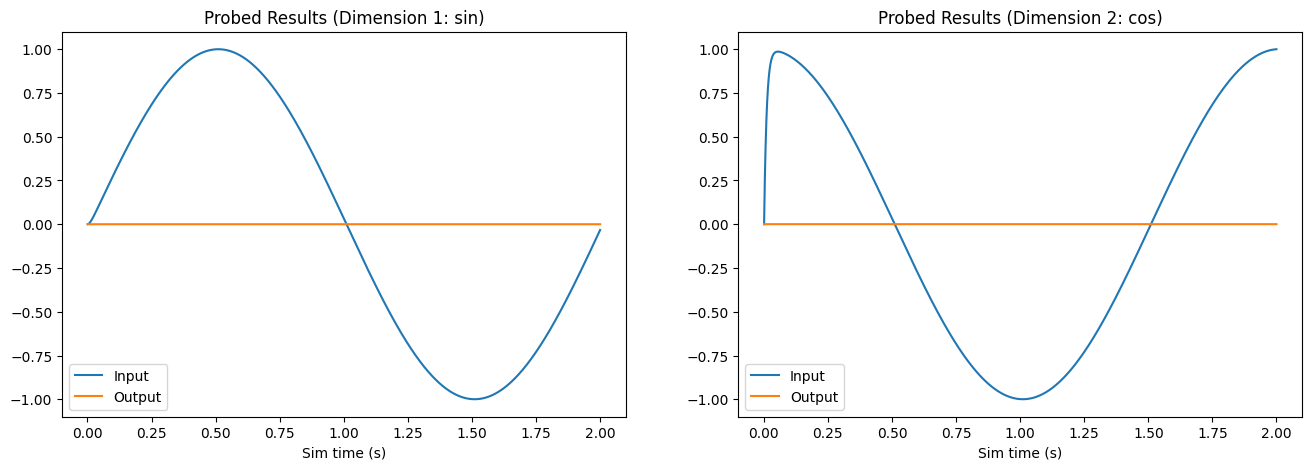

In [7]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.title("Probed Results (Dimension 1: sin)")
plt.plot(sim.trange(), sim.data[input_p][:, 0])
plt.plot(sim.trange(), sim.data[output_p][:, 0])
plt.legend(("Input", "Output"), loc="lower left")
plt.xlabel("Sim time (s)")

plt.subplot(1, 2, 2)
plt.title("Probed Results (Dimension 2: cos)")
plt.plot(sim.trange(), sim.data[input_p][:, 1])
plt.plot(sim.trange(), sim.data[output_p][:, 1])
plt.legend(("Input", "Output"), loc="lower left")
plt.xlabel("Sim time (s)")

plt.show()

Notice that the output for both dimensions is zero, as expected.

## Step 7: Set Weights and Test

Now, we will configure our FPGA ensemble to use the neuron
parameters generated in [Step 3](#Step-3:-Create-Some-Weights).
In order to demonstrate the correct behaviour of the network,
a new Nengo simulation is created and run.

In [8]:
with model:
    # Explicitly set ensemble attributes
    fpga_ens.ensemble.bias = bias
    fpga_ens.ensemble.encoders = encoders
    fpga_ens.ensemble.gain = gain

    # To set the decoders, we need to use nengo.NoSolver
    # to tell the builder we will provide out own decoders
    # (you can also set "weights" here instead,
    # see nengo.solvers.NoSolver for more info)
    fpga_ens.connection.solver = NoSolver(decoders.T)  # Transposed

with nengo_fpga.Simulator(model) as sim:
    sim.run(2)  # Run for 2 seconds

Building network with dummy (non-FPGA) ensemble.


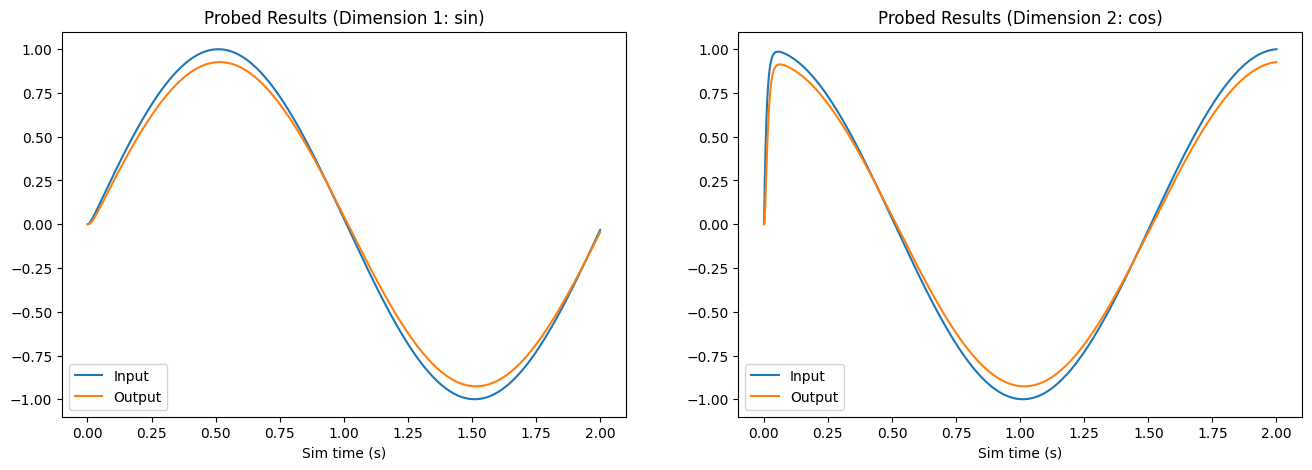

In [9]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.title("Probed Results (Dimension 1: sin)")
plt.plot(sim.trange(), sim.data[input_p][:, 0])
plt.plot(sim.trange(), sim.data[output_p][:, 0])
plt.legend(("Input", "Output"), loc="lower left")
plt.xlabel("Sim time (s)")

plt.subplot(1, 2, 2)
plt.title("Probed Results (Dimension 2: cos)")
plt.plot(sim.trange(), sim.data[input_p][:, 1])
plt.plot(sim.trange(), sim.data[output_p][:, 1])
plt.legend(("Input", "Output"), loc="lower left")
plt.xlabel("Sim time (s)")

plt.show()

As the graphs above illustrate, now that the we've set neuron
parameters to those we generated, the FPGA ensemble behaves
like a communication channel and successfully reproduces
the sine and cosine signals.